In [1]:
# Setup
from data_loader import *
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 14})

Loading bubble data...
✓ Loaded 139446 observations
✓ Timesteps added: 0 to 725
✓ Identified 300 disappearing bubbles
Applying periodic boundary corrections...
✓ Periodic boundary correction applied
✓ Derived quantities computed

DATA LOADING COMPLETE
Total observations:       139,446
Unique bubbles:           400
Timesteps:                0 to 725
Disappearing bubbles:     300
Box size:                 20.203051
Initial avg area (A_0):   1.000000

Available variables:
  - df: Original dataframe
  - df_corrected: Corrected dataframe with actual_area column
  - disappearing_ids: Set of disappearing bubble IDs
  - bubbles_per_timestep: Number of bubbles at each timestep
  - avg_area_per_timestep: Average bubble area at each timestep
  - approx_avg_area: Approximate area from liquid fraction
  - A_0: Initial average bubble area
  - max_timestep: Maximum timestep
  - final_step: Final timestep
  - box_area: Total box area
  - BOX_SIZE, PERIODIC_THRESHOLD, LIQUID_FRACTION: Constants



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1. Low-level helper: 1D autocorrelation via FFT
# ============================================================
def scalar_acf_fft(x, max_lag=None):
    """
    Compute autocorrelation of a 1D array x using FFT.
    Returns C[0:max_lag+1], unnormalised (C[0] = variance * N if mean-subtracted).
    """
    x = np.asarray(x, dtype=float)
    n = len(x)
    if max_lag is None or max_lag > n - 1:
        max_lag = n - 1

    # subtract mean to get covariance-like ACF
    x = x - np.mean(x)

    # zero-pad to avoid circular convolution wrap-around
    nfft = 1 << (2 * n - 1).bit_length()
    f = np.fft.rfft(x, n=nfft)
    # power spectrum
    p = f * np.conjugate(f)
    # inverse FFT to get correlation
    acf = np.fft.irfft(p, n=nfft)[:n]
    # normalise by number of terms contributing at each lag
    norm = np.arange(n, 0, -1, dtype=float)
    acf = acf / norm

    return acf[:max_lag + 1]  # from lag 0..max_lag


# ============================================================
# 2. Helper: average ACF over all bubbles for a given scalar column
# ============================================================
def average_scalar_acf_over_bubbles(df_corrected, col, max_lag):
    """
    Compute average autocorrelation function for a scalar column (e.g. area, Z)
    across all bubbles, up to max_lag.
    Returns:
        lags, C_avg (unnormalised), C_norm (C / C[0])
    """
    C_sum = np.zeros(max_lag + 1)
    counts = np.zeros(max_lag + 1)

    for bubble_id, g in df_corrected.groupby("id"):
        g = g.sort_values("timestep")
        x = g[col].to_numpy()
        if len(x) <= 1:
            continue

        C = scalar_acf_fft(x, max_lag=min(max_lag, len(x) - 1))
        this_lag_len = len(C)

        C_sum[:this_lag_len] += C
        counts[:this_lag_len] += 1

    valid = counts > 0
    C_avg = np.zeros_like(C_sum)
    C_avg[valid] = C_sum[valid] / counts[valid]

    # normalised ACF (C(τ)/C(0))
    C_norm = np.zeros_like(C_avg)
    if C_avg[0] != 0:
        C_norm[valid] = C_avg[valid] / C_avg[0]

    lags = np.arange(max_lag + 1)
    return lags, C_avg, C_norm

In [3]:
# ============================================================
# 3. Velocity autocorrelation C_v(τ)
# ============================================================
def velocity_acf(df_corrected, max_lag):
    """
    Compute velocity autocorrelation:
        C_v(τ) = < v(t)·v(t+τ) >
    where v is 1-step displacement: v = r(t+1) - r(t)
    Returns lags, C_v (unnormalised), C_v_norm.
    """
    Cx_sum = np.zeros(max_lag + 1)
    Cy_sum = np.zeros(max_lag + 1)
    counts = np.zeros(max_lag + 1)

    for bubble_id, g in df_corrected.groupby("id"):
        g = g.sort_values("timestep")
        x = g["x"].to_numpy()
        y = g["y"].to_numpy()

        # 1-step “velocity”
        vx = np.diff(x)
        vy = np.diff(y)

        if len(vx) < 2:  # need at least 2 points for non-zero lag
            continue

        Cx = scalar_acf_fft(vx, max_lag=min(max_lag, len(vx) - 1))
        Cy = scalar_acf_fft(vy, max_lag=min(max_lag, len(vy) - 1))
        this_lag_len = min(len(Cx), len(Cy))

        Cx_sum[:this_lag_len] += Cx[:this_lag_len]
        Cy_sum[:this_lag_len] += Cy[:this_lag_len]
        counts[:this_lag_len] += 1

    valid = counts > 0
    Cx_avg = np.zeros_like(Cx_sum)
    Cy_avg = np.zeros_like(Cy_sum)
    Cx_avg[valid] = Cx_sum[valid] / counts[valid]
    Cy_avg[valid] = Cy_sum[valid] / counts[valid]

    C_v = Cx_avg + Cy_avg  # v·v correlation = Cx + Cy

    C_v_norm = np.zeros_like(C_v)
    if C_v[0] != 0:
        C_v_norm[valid] = C_v[valid] / C_v[0]

    lags = np.arange(max_lag + 1)
    return lags, C_v, C_v_norm


# ============================================================
# 4. Position autocorrelation C_r(τ)
# ============================================================
def position_acf(df_corrected, max_lag):
    """
    Compute position autocorrelation:
        C_r(τ) = < r(t)·r(t+τ) >
    Returns lags, C_r (unnormalised), C_r_norm.
    """
    Cx_sum = np.zeros(max_lag + 1)
    Cy_sum = np.zeros(max_lag + 1)
    counts = np.zeros(max_lag + 1)

    for bubble_id, g in df_corrected.groupby("id"):
        g = g.sort_values("timestep")
        x = g["x"].to_numpy()
        y = g["y"].to_numpy()

        if len(x) < 2:
            continue

        Cx = scalar_acf_fft(x, max_lag=min(max_lag, len(x) - 1))
        Cy = scalar_acf_fft(y, max_lag=min(max_lag, len(y) - 1))
        this_lag_len = min(len(Cx), len(Cy))

        Cx_sum[:this_lag_len] += Cx[:this_lag_len]
        Cy_sum[:this_lag_len] += Cy[:this_lag_len]
        counts[:this_lag_len] += 1

    valid = counts > 0
    Cx_avg = np.zeros_like(Cx_sum)
    Cy_avg = np.zeros_like(Cy_sum)
    Cx_avg[valid] = Cx_sum[valid] / counts[valid]
    Cy_avg[valid] = Cy_sum[valid] / counts[valid]

    C_r = Cx_avg + Cy_avg

    C_r_norm = np.zeros_like(C_r)
    if C_r[0] != 0:
        C_r_norm[valid] = C_r[valid] / C_r[0]

    lags = np.arange(max_lag + 1)
    return lags, C_r, C_r_norm

In [4]:
# ============================================================
# 5. Area autocorrelation C_A(τ)
# ============================================================
def area_acf(df_corrected, max_lag):
    """
    Autocorrelation of bubble area (or radius, whatever is in df["area"]).
    Returns lags, C_A (unnormalised), C_A_norm.
    """
    return average_scalar_acf_over_bubbles(df_corrected, col="area", max_lag=max_lag)


# ============================================================
# 6. Coordination number autocorrelation C_Z(τ)
# ============================================================
def Z_acf(df_corrected, max_lag):
    """
    Autocorrelation of coordination number Z.
    Returns lags, C_Z (unnormalised), C_Z_norm.
    """
    return average_scalar_acf_over_bubbles(df_corrected, col="Z", max_lag=max_lag)

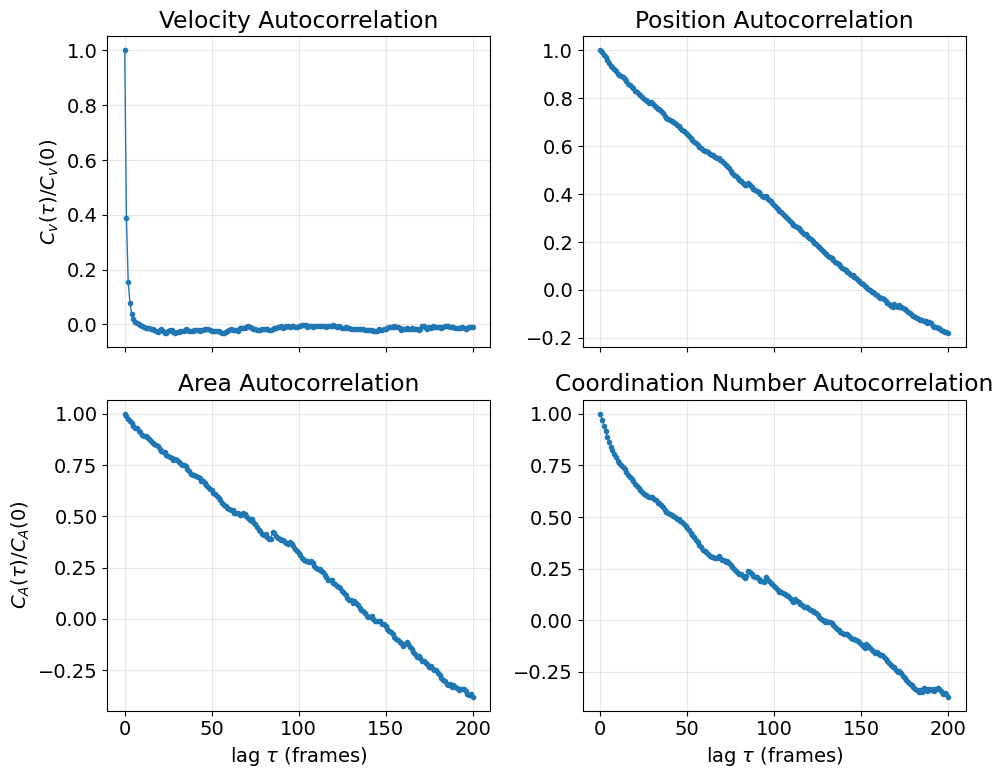

In [5]:
# ============================================================
# 7. Example: run everything & plot
# ============================================================

max_lag = 200  # you can tune this (in frames)

# --- compute ACFs ---
lags_v, C_v, C_v_norm = velocity_acf(df_corrected, max_lag=max_lag)
lags_r, C_r, C_r_norm = position_acf(df_corrected, max_lag=max_lag)
lags_A, C_A, C_A_norm = area_acf(df_corrected, max_lag=max_lag)
lags_Z, C_Z, C_Z_norm = Z_acf(df_corrected, max_lag=max_lag)

# --- plotting: 4-panel figure of normalised ACFs ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
(ax1, ax2), (ax3, ax4) = axes

# Velocity ACF
ax1.plot(lags_v, C_v_norm, marker='o', ms=3, lw=1)
ax1.set_title("Velocity Autocorrelation")
ax1.set_ylabel(r"$C_v(\tau)/C_v(0)$")
ax1.grid(alpha=0.3)

# Position ACF
ax2.plot(lags_r, C_r_norm, marker='o', ms=3, lw=1)
ax2.set_title("Position Autocorrelation")
ax2.grid(alpha=0.3)

# Area ACF
ax3.plot(lags_A, C_A_norm, marker='o', ms=3, lw=1)
ax3.set_title("Area Autocorrelation")
ax3.set_xlabel(r"lag $\tau$ (frames)")
ax3.set_ylabel(r"$C_A(\tau)/C_A(0)$")
ax3.grid(alpha=0.3)

# Z ACF
ax4.plot(lags_Z, C_Z_norm, marker='o', ms=3, lw=1)
ax4.set_title("Coordination Number Autocorrelation")
ax4.set_xlabel(r"lag $\tau$ (frames)")
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
def correlation_time(lags, C_norm, stop_at_zero_cross=True):
    """
    Estimate correlation time τ_c from a normalised ACF C_norm(τ).
    
    Parameters
    ----------
    lags : array-like
        Lag values (integer timesteps).
    C_norm : array-like
        Normalised autocorrelation C(τ)/C(0).
    stop_at_zero_cross : bool
        If True, stop summing at the first lag where the ACF
        becomes non-positive (≤ 0).
    
    Returns
    -------
    tau_c : float
        Estimated correlation time in units of timesteps.
    """
    lags = np.asarray(lags)
    C_norm = np.asarray(C_norm)

    if stop_at_zero_cross:
        # find first index where ACF ≤ 0 (after lag 0)
        mask = np.where(C_norm[1:] <= 0)[0]
        if len(mask) > 0:
            cut_index = mask[0] + 1  # +1 offset because we started from index 1
        else:
            cut_index = len(C_norm)
    else:
        cut_index = len(C_norm)

    # sum from τ=0 to τ=cut_index-1
    tau_c = np.sum(C_norm[:cut_index])  # Δt = 1 per frame

    return tau_c

In [7]:
tau_c_v  = correlation_time(lags_v, C_v_norm)
tau_c_r  = correlation_time(lags_r, C_r_norm)
tau_c_A  = correlation_time(lags_A, C_A_norm)
tau_c_Z  = correlation_time(lags_Z, C_Z_norm)

print(f"Velocity correlation time τ_c^v  ≈ {tau_c_v:.1f} frames")
print(f"Position correlation time τ_c^r  ≈ {tau_c_r:.1f} frames")
print(f"Area correlation time τ_c^A      ≈ {tau_c_A:.1f} frames")
print(f"Z correlation time τ_c^Z         ≈ {tau_c_Z:.1f} frames")

Velocity correlation time τ_c^v  ≈ 1.7 frames
Position correlation time τ_c^r  ≈ 75.3 frames
Area correlation time τ_c^A      ≈ 70.7 frames
Z correlation time τ_c^Z         ≈ 49.1 frames


In [8]:
# ============================================================
# Split df_corrected into early and late based on timestep
# ============================================================
all_timesteps = df_corrected["timestep"].to_numpy()
t_med = np.median(all_timesteps)

df_early = df_corrected[df_corrected["timestep"] <= t_med].copy()
df_late  = df_corrected[df_corrected["timestep"] >  t_med].copy()

print("Median timestep:", t_med)
print("Early timesteps:  min =", df_early["timestep"].min(), 
      "max =", df_early["timestep"].max())
print("Late timesteps:   min =", df_late["timestep"].min(), 
      "max =", df_late["timestep"].max())

Median timestep: 245.0
Early timesteps:  min = 0 max = 245
Late timesteps:   min = 246 max = 725


[Velocity] τ_c early ≈ 1.7 frames
[Velocity] τ_c late  ≈ 1.5 frames


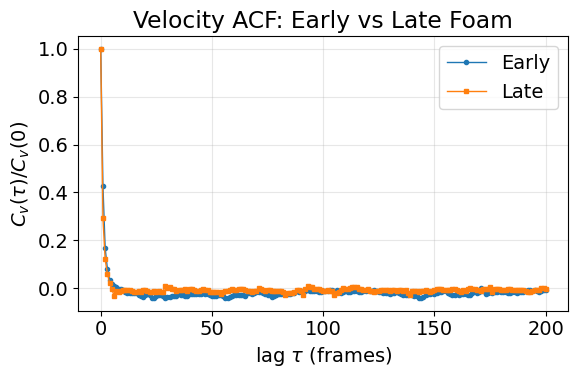

In [9]:
max_lag = 200  # you can adjust if needed

# Velocity ACF for early and late
lags_v_e, C_v_e, C_v_e_norm = velocity_acf(df_early, max_lag=max_lag)
lags_v_l, C_v_l, C_v_l_norm = velocity_acf(df_late,  max_lag=max_lag)

# Correlation times
tau_c_v_e = correlation_time(lags_v_e, C_v_e_norm)
tau_c_v_l = correlation_time(lags_v_l, C_v_l_norm)

print(f"[Velocity] τ_c early ≈ {tau_c_v_e:.1f} frames")
print(f"[Velocity] τ_c late  ≈ {tau_c_v_l:.1f} frames")

# Plot
plt.figure(figsize=(6,4))
plt.plot(lags_v_e, C_v_e_norm, marker='o', ms=3, lw=1, label='Early')
plt.plot(lags_v_l, C_v_l_norm, marker='s', ms=3, lw=1, label='Late')
plt.xlabel(r"lag $\tau$ (frames)")
plt.ylabel(r"$C_v(\tau)/C_v(0)$")
plt.title("Velocity ACF: Early vs Late Foam")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

[Area] τ_c early ≈ 27.2 frames
[Area] τ_c late  ≈ 56.9 frames


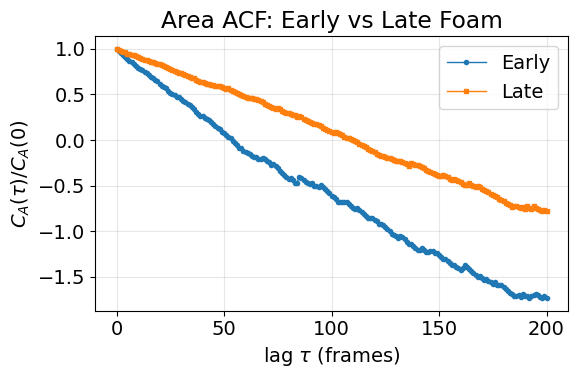

In [10]:
# Area ACF for early and late
lags_A_e, C_A_e, C_A_e_norm = area_acf(df_early, max_lag=max_lag)
lags_A_l, C_A_l, C_A_l_norm = area_acf(df_late,  max_lag=max_lag)

tau_c_A_e = correlation_time(lags_A_e, C_A_e_norm)
tau_c_A_l = correlation_time(lags_A_l, C_A_l_norm)

print(f"[Area] τ_c early ≈ {tau_c_A_e:.1f} frames")
print(f"[Area] τ_c late  ≈ {tau_c_A_l:.1f} frames")

plt.figure(figsize=(6,4))
plt.plot(lags_A_e, C_A_e_norm, marker='o', ms=3, lw=1, label='Early')
plt.plot(lags_A_l, C_A_l_norm, marker='s', ms=3, lw=1, label='Late')
plt.xlabel(r"lag $\tau$ (frames)")
plt.ylabel(r"$C_A(\tau)/C_A(0)$")
plt.title("Area ACF: Early vs Late Foam")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

[Z] τ_c early ≈ 22.5 frames
[Z] τ_c late  ≈ 45.8 frames


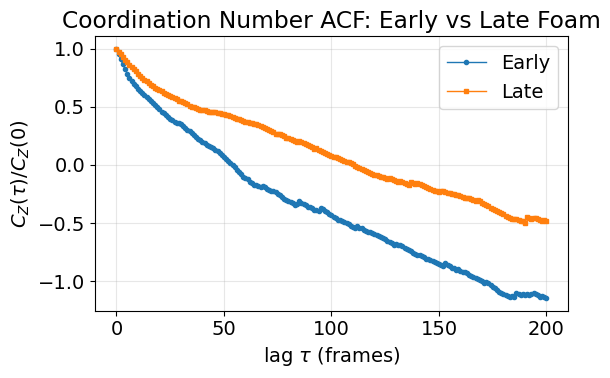

In [11]:
# Z ACF for early and late
lags_Z_e, C_Z_e, C_Z_e_norm = Z_acf(df_early, max_lag=max_lag)
lags_Z_l, C_Z_l, C_Z_l_norm = Z_acf(df_late,  max_lag=max_lag)

tau_c_Z_e = correlation_time(lags_Z_e, C_Z_e_norm)
tau_c_Z_l = correlation_time(lags_Z_l, C_Z_l_norm)

print(f"[Z] τ_c early ≈ {tau_c_Z_e:.1f} frames")
print(f"[Z] τ_c late  ≈ {tau_c_Z_l:.1f} frames")

plt.figure(figsize=(6,4))
plt.plot(lags_Z_e, C_Z_e_norm, marker='o', ms=3, lw=1, label='Early')
plt.plot(lags_Z_l, C_Z_l_norm, marker='s', ms=3, lw=1, label='Late')
plt.xlabel(r"lag $\tau$ (frames)")
plt.ylabel(r"$C_Z(\tau)/C_Z(0)$")
plt.title("Coordination Number ACF: Early vs Late Foam")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

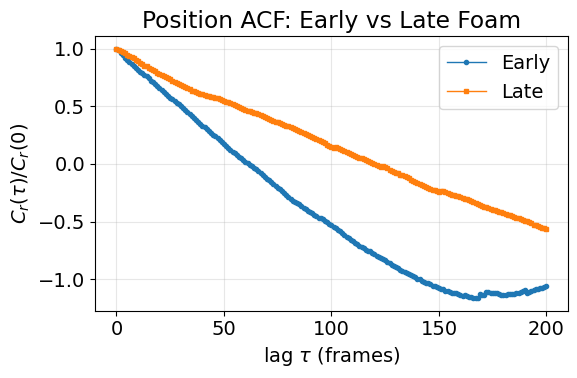

In [12]:
lags_r_e, C_r_e, C_r_e_norm = position_acf(df_early, max_lag=max_lag)
lags_r_l, C_r_l, C_r_l_norm = position_acf(df_late,  max_lag=max_lag)

plt.figure(figsize=(6,4))
plt.plot(lags_r_e, C_r_e_norm, marker='o', ms=3, lw=1, label='Early')
plt.plot(lags_r_l, C_r_l_norm, marker='s', ms=3, lw=1, label='Late')
plt.xlabel(r"lag $\tau$ (frames)")
plt.ylabel(r"$C_r(\tau)/C_r(0)$")
plt.title("Position ACF: Early vs Late Foam")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()